In [1]:
#Veriyi okuma ve işleme için
import cv2
import urllib
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import random, os, glob
from imutils import paths
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from urllib.request import urlopen

#Warningleri kapatmak için
import warnings
warnings.filterwarnings("ignore")

#Model değerlendirme için
from sklearn.metrics import confusion_matrix, classification_report

#Model için
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, SpatialDropout2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [3]:
dir_path = "Garbage classification"

In [4]:
target_size = (224,224)

waste_labels = {"cardboard": 0, "glass": 1, "metal": 2, "paper": 3, "plastic": 4, "trash": 5}

In [5]:
def load_datasets(path):
  """
  Görsellerin bulunduğu dizindeki görüntüyü okuyup etiketlerini oluşturur.

  Parametreler:

  path: Görsellerin bulunduğu dizini ifade eder.

  Return:

  x: Görüntülere ait matris bilgilerini tutar.

  labels: Görüntünün ait olduğu sınıf bilgisini tutan liste
  """

  x = []
  labels = []

  # Gönderdiğimiz pathdeki görüntüleri listeleyip sıralamaktadır.
  image_paths = sorted(list(paths.list_images(path)))

  for image_path in image_paths:
    #Belirtilen pathdeki görüntüler openCV kütüphanesi ile okunmaktadır.
    img = cv2.imread(image_path)

    #Okunan görüntüler başlangıçta belirlenen target_size'a göre yeniden ölçeklendirilir.
    img = cv2.resize(img, target_size)

    #Ölçeklendirilen görüntüler x listesine eklenir.
    x.append(img)

    #Her bir path '/' ifadesi ile ayrıldığında dönen listenin sondan ikinci elemanı labelı temsil etmektedir.
    label = image_path.split(os.path.sep)[-2]

    #Yakalanan labelların sayısal değer karşılıklarının olduğu waste_labels sözlüğü içerisinden gönderilern key
    #değerine karşılık value değeri alınarak label oluşturulur.
    labels.append(waste_labels[label])

  # Veri seti random bir şekilde karıştırılır.
  x, labels = shuffle(x, labels, random_state = 42)

  # Boyut ve sınıf bilgisi raporlanmaktadır.
  print(f"X boyutu: {np.array(x).shape}")
  print(f"Label sınıf sayısı: {len(np.unique(labels))} Gözlem sayısı: {len(labels)}")

  return x, labels

In [6]:
x, labels = load_datasets(dir_path)

X boyutu: (2527, 224, 224, 3)
Label sınıf sayısı: 6 Gözlem sayısı: 2527


In [7]:
# Görüntü boyutlarının tutulması
input_shape = (np.array(x[0]).shape[1], np.array(x[0]).shape[1], 3)
print(input_shape)

(224, 224, 3)


In [8]:
def visualize_img(image_batch, label_batch):
  """

  Veriseti içerisinden görüntü görselleştirir.

  Parametreler:

  image_batch: Görüntülere ait matris bilgilerini tutar.

  label_batch: Görüntünün ait olduğu sınıf bilgilerini tutan liste.

  """

  plt.figure(figsize=(10,10))
  for n in range(10):
    ax = plt.subplot(5,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(np.array(list(waste_labels.keys()))[to_categorical(labels, num_classes=6)[n]==1][0].title())
    plt.axis("off")

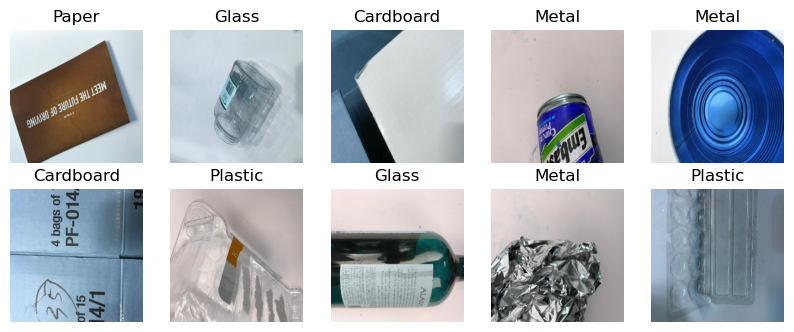

In [9]:
visualize_img(x, labels)

In [10]:
# Train veriseti için bir generator tanımlıyoruz.
train = ImageDataGenerator(horizontal_flip=True,
                           vertical_flip=True,
                           validation_split=0.1,
                           rescale=1./255,
                           shear_range=0.1,
                           zoom_range=0.1,
                           width_shift_range=0.1,
                           height_shift_range=0.1)
#Test veriseti için bir generator tanımlıyoruz.
test = ImageDataGenerator(rescale=1/255,
                          validation_split=0.1)

In [11]:
train_generator = train.flow_from_directory(directory = dir_path,
                                            target_size = (target_size),
                                            class_mode = "categorical",
                                            subset = "training")
test_generator = test.flow_from_directory(directory = dir_path,
                                          target_size = (target_size),
                                          batch_size = 251,
                                          class_mode = "categorical",
                                          subset = "validation")

Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.


In [12]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", input_shape=(input_shape), activation="relu"))
model.add(MaxPooling2D(pool_size=2, strides=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", input_shape=(input_shape), activation="relu"))
model.add(MaxPooling2D(pool_size=2, strides=(2,2)))

model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", input_shape=(input_shape), activation="relu"))
model.add(MaxPooling2D(pool_size=2, strides=(2,2)))

model.add(Flatten())

model.add(Dense(units=64, activation="relu"))
model.add(Dropout(rate=0.2))

model.add(Dense(units=32, activation="relu"))
model.add(Dropout(rate=0.2))

model.add(Dense(units=6, activation="softmax"))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 32)       0

In [14]:
model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), "acc"])

In [15]:
callbacks = [EarlyStopping(monitor="val_loss", patience=50, verbose=1, mode="min"),
             ModelCheckpoint(filepath="mymodel.h5", monitor="val_loss", mode="min", save_best_only=True, save_weights_only=False, verbose=1)]

In [16]:
history = model.fit_generator(generator=train_generator,
                              epochs=100,
                              validation_data=test_generator,
                              callbacks=callbacks,
                              workers=4,
                              steps_per_epoch=2276//32,
                              validation_steps=251//32)

Epoch 1/100
21/71 [=======>......................] - ETA: 19s - loss: 1.8034 - precision: 0.2857 - recall: 0.0089 - acc: 0.2277

KeyboardInterrupt: 

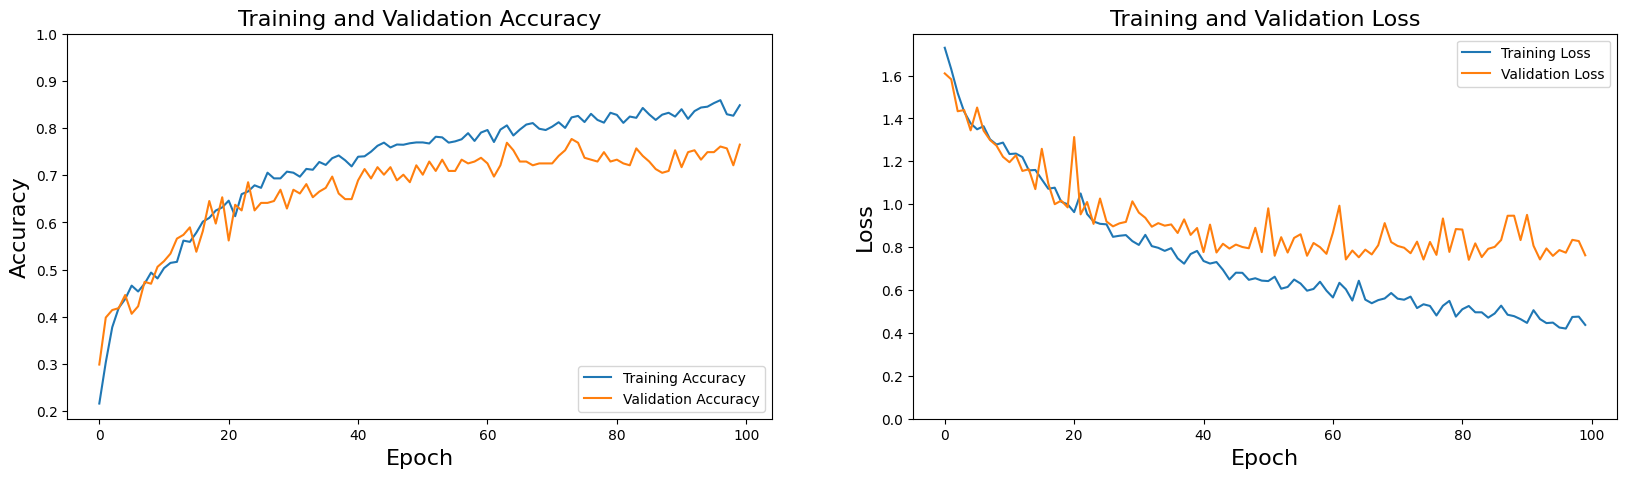

In [ ]:
# Accuracy Grafiği
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["acc"], label="Training Accuracy")
plt.plot(history.history["val_acc"], label="Validation Accuracy")
plt.legend(loc="lower right")
plt.xlabel("Epoch", fontsize=16)
plt.ylabel("Accuracy", fontsize=16)
plt.ylim([min(plt.ylim()), 1])
plt.title("Training and Validation Accuracy", fontsize=16)

# Loss Grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend(loc="upper right")
plt.xlabel("Epoch", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.ylim([0, max(plt.ylim())])
plt.title("Training and Validation Loss", fontsize=16)
plt.show()

In [ ]:
loss, precision, recall, acc = model.evaluate(test_generator, batch_size=32)

1/1 [==============================] - 1s 1s/step - loss: 0.7620 - precision: 0.8044 - recall: 0.7211 - acc: 0.7649


In [ ]:
print("\nTest accuracy: %.lf%%" % (100.0 * acc))
print("\nTest loss: %.lf%%" % (100.0 * loss))
print("\nTest precision: %.lf%%" % (100.0 * precision))
print("\nTest recall: %.lf%%" % (100.0 * recall))


Test accuracy: 76%

Test loss: 76%

Test precision: 80%

Test recall: 72%


In [ ]:
# Classification Report
x_test, y_test = test_generator.next()

y_pred = model.predict(x_test)

y_pred = np.argmax(y_pred, axis=1)

y_test = np.argmax(y_test, axis=1)

8/8 [==============================] - 1s 86ms/step


In [ ]:
target_names = list(waste_labels.keys())

In [ ]:
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

   cardboard       0.85      0.72      0.78        40
       glass       0.75      0.84      0.79        50
       metal       0.68      0.73      0.71        41
       paper       0.82      0.90      0.85        59
     plastic       0.77      0.56      0.65        48
       trash       0.65      0.85      0.73        13

    accuracy                           0.76       251
   macro avg       0.75      0.77      0.75       251
weighted avg       0.77      0.76      0.76       251



In [ ]:
# Confusion Matrix

cm = confusion_matrix(y_test, y_pred)

def plot_confusion_matrix(cm, classes, normalize=False, title="Confusion matrix", cmap=plt.cm.Blues):
  """
  Bu fonksiyon karışıklık matrisini çizer ve ekrana gösterir.
  "normalize=True" yapılarak standartlaştırma kapatılabilir.
  """
  if normalize:
    cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

  plt.figure(figsize=(8, 6))
  plt.imshow(cm, interpolation="nearest", cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)
  fmt = ".2f" if normalize else "d"
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i,j] > thresh else "black")
  plt.tight_layout()
  plt.ylabel("True label", fontweight="bold")
  plt.xlabel("Predicted label", fontweight="bold")

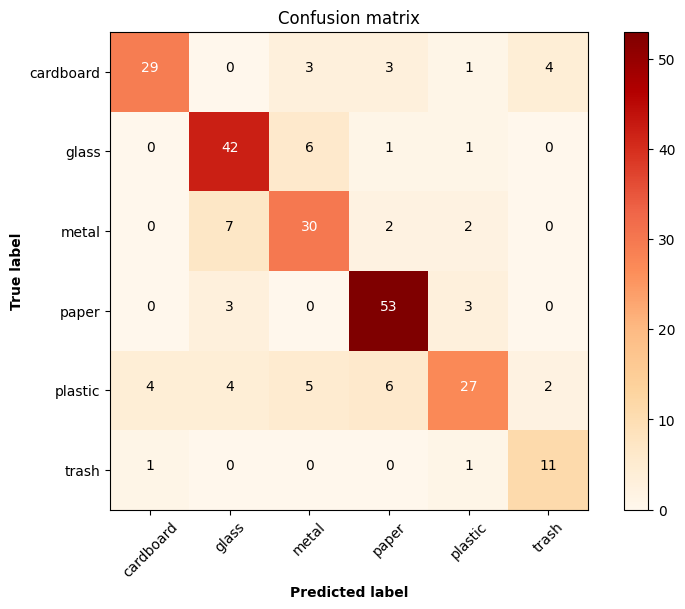

In [ ]:
plot_confusion_matrix(cm, waste_labels.keys(), title="Confusion matrix", cmap=plt.cm.OrRd)

In [ ]:
waste_labels = {0: "cardboard", 1: "glass", 2: "metal", 3: "paper", 4: "plastic", 5: "trash"}

In [ ]:
def model_testing(path):
  """
  Görsellerin bulunduğu dizindeki görüntüyü okuyup model aracılığı ile hangi sınıfa ait olduğuna dair tahmin işlemi gerçekleştirilir.

  Parametreler:

  path: Görsellerin bulunduğu dizini ifade eder.

  Return:

  img: Görüntü

  p: Tahmin olasılıkları

  predicted_class: Tahmin sınıfı

  """
  img = image.load_img(path, target_size=(target_size))
  img = image.img_to_array(img, dtype=np.uint8)
  img = np.array(img) / 255.0
  p = model.predict(img.reshape(1, 224, 224, 3))
  predicted_class = np.argmax(p[0])

  return img, p, predicted_class

In [ ]:
img1, p1, predicted_class1 = model_testing("/content/drive/MyDrive/Garbage classification/metal/metal101.jpg")
img2, p2, predicted_class2 = model_testing("/content/drive/MyDrive/Garbage classification/glass/glass101.jpg")
img3, p3, predicted_class3 = model_testing("/content/drive/MyDrive/Garbage classification/cardboard/cardboard101.jpg")
img4, p4, predicted_class4 = model_testing("/content/drive/MyDrive/Garbage classification/paper/paper101.jpg")

1/1 [==============================] - 0s 17ms/step


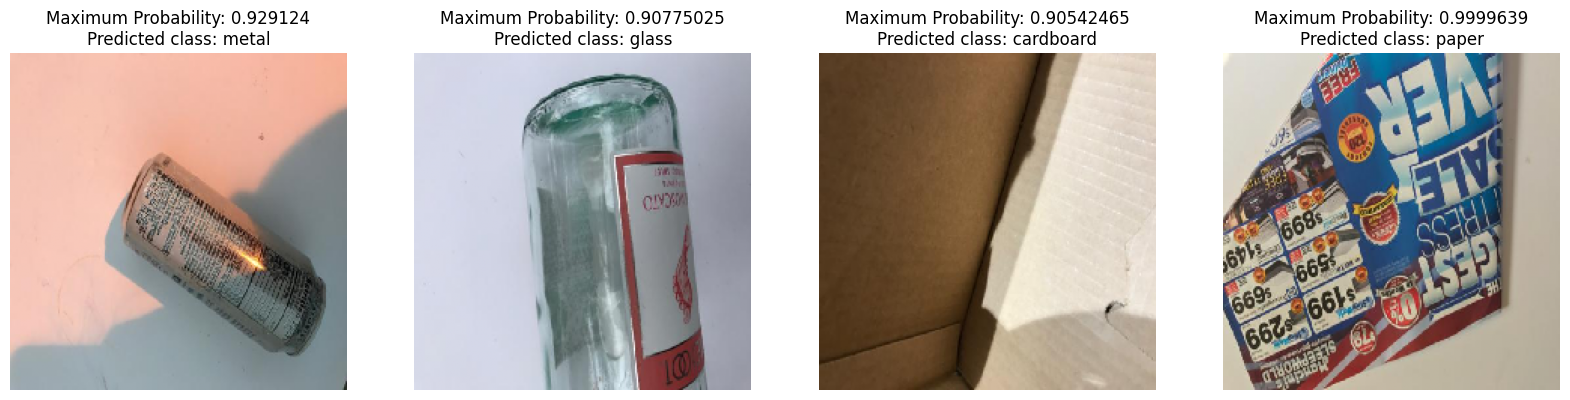

In [ ]:
plt.figure(figsize=(20,60))

plt.subplot(141)
plt.axis("off")
plt.imshow(img1.squeeze())
plt.title("Maximum Probability: " + str(np.max(p1[0], axis=-1)) + "\n" + "Predicted class: " + str(waste_labels[predicted_class1]))
plt.imshow(img1)

plt.subplot(142)
plt.axis("off")
plt.imshow(img2.squeeze())
plt.title("Maximum Probability: " + str(np.max(p2[0], axis=-1)) + "\n" + "Predicted class: " + str(waste_labels[predicted_class2]))
plt.imshow(img2)

plt.subplot(143)
plt.axis("off")
plt.imshow(img3.squeeze())
plt.title("Maximum Probability: " + str(np.max(p3[0], axis=-1)) + "\n" + "Predicted class: " + str(waste_labels[predicted_class3]))
plt.imshow(img3)

plt.subplot(144)
plt.axis("off")
plt.imshow(img4.squeeze())
plt.title("Maximum Probability: " + str(np.max(p4[0], axis=-1)) + "\n" + "Predicted class: " + str(waste_labels[predicted_class4]))
plt.imshow(img4)